# D2L: Recurrent Neural Networks

## 8.1 Sequence Models

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
# torch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
# from d2l import torch as d2l

Generate sequence data by using a sine function with some additive noise for timesteps: `1, 2, ..., 1000`

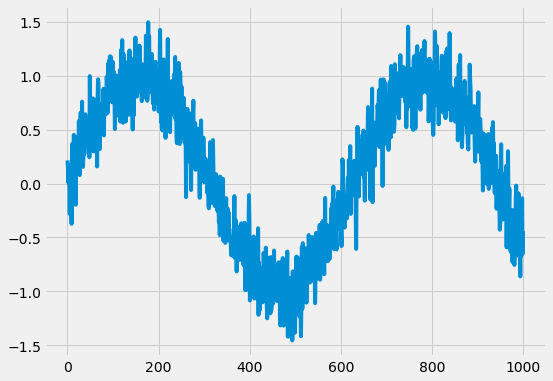

In [11]:
# generate 1000 points
T = 1000
# return a 1-D tensor of interval [start, end)
time = torch.arange(1, T+1, dtype=torch.float32)
# sine function with additive noise
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
# plot
plt.figure(figsize=(8,6))
plt.plot(x)
plt.show();

#### Develop features and labels

$\tau = 4$

TRAIN_SIZE = 600

In [24]:
tau = 4
features = torch.zeros((T-tau, tau))
print("Shape of features: ", features.shape)
# assign values to features array
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels = x[tau:].reshape((-1,1))

Shape of features:  torch.Size([996, 4])


In [26]:
batch_size, n_train = 16, 600

train_dataset = TensorDataset(features[:n_train], labels[:n_train])
train_iter = DataLoader(train_dataset, batch_size=batch_size)

#### Define model architecture

2 fully-connected layers, ReLU activation and squared loss.

In [37]:
# function for initializing weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
# a simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(4,10), nn.ReLU(), nn.Linear(10,1))
    net.apply(init_weights)
    return net

# square loss
loss = nn.MSELoss()

#### Train the model

In [38]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            trainer.step()
        print(f"Epoch: {epoch+1}",
              f"Loss: {l}")

In [39]:
net = get_net()
train(net, train_iter, loss, epochs=5, lr=0.01)

Epoch: 1 Loss: 0.11002394556999207
Epoch: 2 Loss: 0.06374600529670715
Epoch: 3 Loss: 0.0640769749879837
Epoch: 4 Loss: 0.07713647186756134
Epoch: 5 Loss: 0.12077925354242325


#### Prediction

Check *one-step-ahead prediction* i.e. predict what happens just in the next time-step.

In [51]:
onestep_preds.detach().numpy().shape

(996, 1)

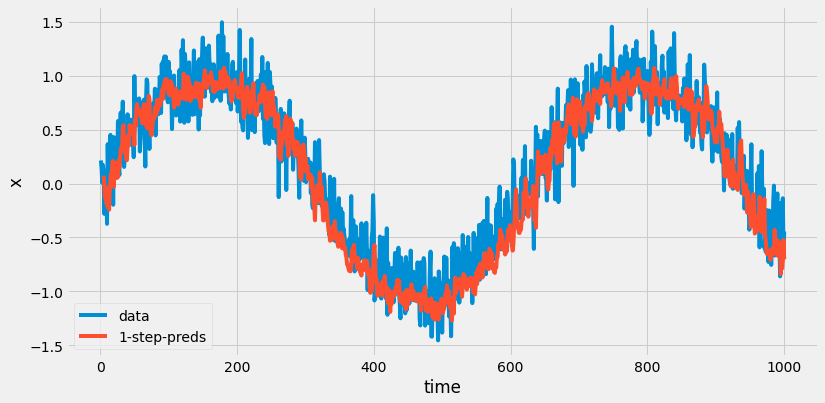

In [54]:
onestep_preds = net(features)
plt.figure(figsize=(12,6))
plt.plot(time, x.detach().numpy(), label='data')
plt.plot(time[tau:], onestep_preds.detach().numpy(), label='1-step-preds')

plt.xlabel('time')
plt.ylabel('x')
plt.legend()
plt.show();

#### k-step ahead prediction

Here we are using our own prediction i.e. from timestep `604 and beyond` to predict further timesteps.

In [58]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]

for i in range(n_train+tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1,-1)))

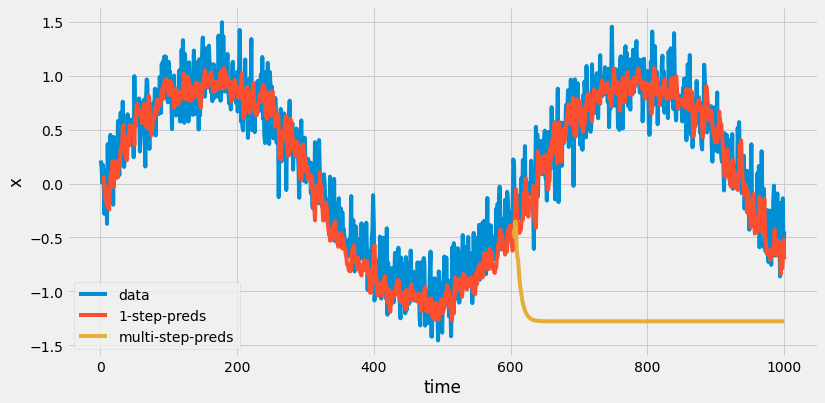

In [59]:
onestep_preds = net(features)
plt.figure(figsize=(12,6))
plt.plot(time, x.detach().numpy(), label='data')
plt.plot(time[tau:], onestep_preds.detach().numpy(), label='1-step-preds')
plt.plot(time[n_train+tau:], multistep_preds[n_train+tau:].detach().numpy(), label='multi-step-preds')

plt.xlabel('time')
plt.ylabel('x')
plt.legend()
plt.show();